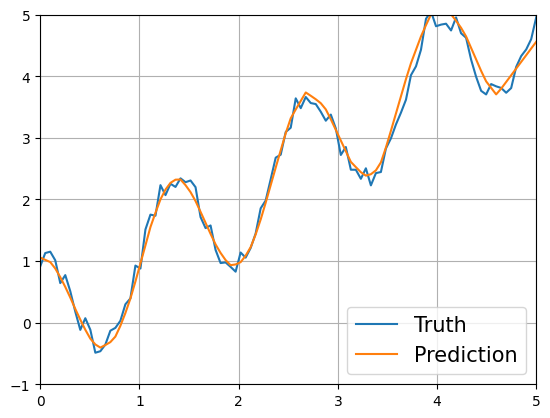

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # OMP 중복 허용

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,128)
        self.fc4 = nn.Linear(128, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
def true_fun(X):
    noise = np.random.rand(X.shape[0]) * 0.4 - 0.2
    return np.cos(1.5 * np.pi * X) + X + noise

def plot_results(model):
    x = np.linspace(0, 5, 100)
    input_x = torch.from_numpy(x).float().unsqueeze(1)
    plt.plot(x, true_fun(x), label='Truth')
    plt.plot(x, model(input_x).detach().numpy(), label='Prediction')
    plt.legend(loc='lower right', fontsize=15)
    plt.xlim((0,5))
    plt.ylim((-1,5))
    plt.grid()
    plt.show()

def main():
    data_x = np.random.rand(10000) * 5
    model = Model()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for step in range(10000):
        batch_x = np.random.choice(data_x, 32)
        batch_x_tensor = torch.from_numpy(batch_x).float().unsqueeze(1)
        pred = model(batch_x_tensor)

        batch_y = true_fun(batch_x)
        truth = torch.from_numpy(batch_y).float().unsqueeze(1)
        loss = F.mse_loss(pred, truth)

        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()

    plot_results(model)

if __name__ == '__main__':
    main()

In [17]:
import gym
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)
    
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()
        

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size) #리플레이 

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def main():
    env = gym.make("CartPole-v1")
    q = Qnet() 
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(5000):
        epsilon = max(0.01, 0.08-0.01*(n_epi/200))    
        s = env.reset()[0]
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info, _ = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s, a, r/200.0, s_prime, done_mask))
            s = s_prime
            score += r
            if done:
                break
        
        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode : {}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
    
    env.close()

if __name__ == '__main__':
    main()

n_episode : 20, score : 10.1, n_buffer : 201, eps : 7.9%
n_episode : 40, score : 9.4, n_buffer : 389, eps : 7.8%
n_episode : 60, score : 9.8, n_buffer : 585, eps : 7.7%
n_episode : 80, score : 9.3, n_buffer : 771, eps : 7.6%
n_episode : 100, score : 10.1, n_buffer : 973, eps : 7.5%
n_episode : 120, score : 9.5, n_buffer : 1163, eps : 7.4%
n_episode : 140, score : 9.5, n_buffer : 1353, eps : 7.3%
n_episode : 160, score : 9.9, n_buffer : 1551, eps : 7.2%
n_episode : 180, score : 9.9, n_buffer : 1750, eps : 7.1%
n_episode : 200, score : 9.7, n_buffer : 1943, eps : 7.0%
n_episode : 220, score : 11.4, n_buffer : 2171, eps : 6.9%
n_episode : 240, score : 19.8, n_buffer : 2566, eps : 6.8%
n_episode : 260, score : 21.4, n_buffer : 2994, eps : 6.7%
n_episode : 280, score : 21.9, n_buffer : 3433, eps : 6.6%
n_episode : 300, score : 24.4, n_buffer : 3920, eps : 6.5%
n_episode : 320, score : 25.7, n_buffer : 4434, eps : 6.4%
n_episode : 340, score : 111.8, n_buffer : 6670, eps : 6.3%
n_episode : 3

KeyboardInterrupt: 